In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import perceptron
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
import warnings

%matplotlib inline
warnings.filterwarnings('ignore') # Suppress warnings

/usr/local/miniconda3/envs/datax/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data Cleaning

Consolidate some columns

In [2]:
shenzhen = pd.read_csv("Data/shenzhen_cleaned_data.csv")
shenzhen['acid_feed'] = shenzhen['1_acidification_hydrolysis_tank_feed_'] \
                                             + shenzhen['2_acidification_hydrolysis_tank_feed_']
shenzhen['acid_discharge']  = shenzhen['1_acidification_hydrolysis_tank_discharge_']\
                                             + shenzhen['2_acidification_hydrolysis_tank_discharge_']
shenzhen['anaerobic_feed'] = shenzhen['1_Anaerobic_tank_slurry_feed_'] \
                                             + shenzhen['2_Anaerobic_tank_slurry_feed_']
shenzhen['anaerobic_cumuprod'] = shenzhen['1_Anaerobic_tank_biogas_cumulative_production_'] \
                                             + shenzhen['2_anaerobic_tank_biogas_cumulative_production_']
shenzhen['anaerobic_dailyoutput'] = shenzhen['1_anaerobic_tank_biogas_daily_output_'] \
                                             + shenzhen['2_anaerobic_tank_biogas_daily_output_']
shenzhen = shenzhen.drop(['1_acidification_hydrolysis_tank_feed_','2_acidification_hydrolysis_tank_feed_',\
               '1_acidification_hydrolysis_tank_discharge_','2_acidification_hydrolysis_tank_discharge_',\
               '1_Anaerobic_tank_slurry_feed_','2_Anaerobic_tank_slurry_feed_',\
               '1_Anaerobic_tank_biogas_cumulative_production_','2_anaerobic_tank_biogas_cumulative_production_',\
               '1_anaerobic_tank_biogas_daily_output_','2_anaerobic_tank_biogas_daily_output_'],axis=1)

shenzhen.head()

,Unnamed: 0,Kitchen_waste_,Fruit_and_vegetable_waste_,Bread_Paste_,Waste_oil_,Total_Waste_,Diesel_waste_water_,Flour_and_waste_oil_,Kitchen_waste_paste_,acid_feed,acid_discharge,anaerobic_feed,anaerobic_cumuprod,anaerobic_dailyoutput
0,0,92.03,0.0,7.95,13.54,99.98,54.0,17.0,167.0,0.0,0.0,130.0,340453.0,7919.0
1,1,78.43,0.0,13.30,16.10,91.73,36.0,8.0,100.0,0.0,0.0,170.0,343154.0,2701.0
2,2,81.84,0.0,8.35,6.60,90.19,22.0,34.0,120.0,0.0,0.0,150.0,353361.0,10207.0
3,3,81.05,0.0,9.10,17.48,90.15,22.0,20.0,92.0,0.0,0.0,160.0,363943.0,10582.0
4,4,36.86,0.0,9.40,12.47,46.26,44.0,35.0,122.0,0.0,0.0,160.0,372971.0,9028.0


Shift rows up to account for production delay

In [3]:
shenzhen.acid_feed = shenzhen.acid_feed.shift(-15)
shenzhen.acid_discharge = shenzhen.acid_discharge.shift(-15)
shenzhen.anaerobic_feed = shenzhen.anaerobic_feed.shift(-15)
shenzhen.anaerobic_cumuprod = shenzhen.anaerobic_cumuprod.shift(-15)
shenzhen.anaerobic_dailyoutput = shenzhen.anaerobic_dailyoutput.shift(-15)
shenzhen = shenzhen.drop(['Unnamed: 0'], axis=1)
shenzhen = shenzhen[:-15]
shenzhen.tail()

,Kitchen_waste_,Fruit_and_vegetable_waste_,Bread_Paste_,Waste_oil_,Total_Waste_,Diesel_waste_water_,Flour_and_waste_oil_,Kitchen_waste_paste_,acid_feed,acid_discharge,anaerobic_feed,anaerobic_cumuprod,anaerobic_dailyoutput
436,150.03,25.45,0.0,6.49,175.48,44.0,0.0,151.0,0.0,200.0,200.0,3091363.0,7526.0
437,144.28,49.36,0.0,10.04,193.64,44.0,0.0,145.0,0.0,210.0,210.0,3098699.0,7336.0
438,98.96,32.86,0.0,9.79,131.82,0.0,0.0,101.0,0.0,230.0,230.0,3105678.0,6979.0
439,86.92,32.11,0.0,11.71,119.03,44.0,0.0,89.0,0.0,220.0,220.0,3112064.0,6626.0
440,158.93,33.02,0.0,9.10,191.95,0.0,0.0,160.0,0.0,230.0,230.0,3119057.0,6993.0


# Preliminary Work

### Regression with normalized columns

Normalize the data

In [4]:
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(shenzhen)
shenzhen_normalized = pd.DataFrame(np_scaled)
shenzhen_normalized.columns = ['Kitchen_waste_',\
       'Fruit_and_vegetable_waste_', 'Bread_Paste_', 'Waste_oil_',\
       'Total_Waste_', 'Diesel_waste_water_', 'Flour_and_waste_oil_',\
       'Kitchen_waste_paste_', 'acid_feed', 'acid_discharge', 'anaerobic_feed',\
       'anaerobic_cumuprod', 'anaerobic_dailyoutput']

In [5]:
train_data, test_data = train_test_split(shenzhen_normalized, test_size=0.15)

Set the train and test data

In [6]:
COLUMNS = [ 'Kitchen_waste_', 'Fruit_and_vegetable_waste_', 'Bread_Paste_',\
            'Waste_oil_', 'Total_Waste_', 'Diesel_waste_water_', \
            'Flour_and_waste_oil_', 'Kitchen_waste_paste_' ]

X_train = train_data[COLUMNS]
y_train = train_data['anaerobic_dailyoutput']
X_test = test_data[COLUMNS]
y_test = test_data['anaerobic_dailyoutput']

Run KNN regression on the normalized data

In [7]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

print('Accuracy of kNN on training set: {:.2f}'.format(knn.score(X_train, y_train)))
print('Accuracy of kNN on test set: {:.2f}'.format(knn.score(X_test, y_test)))

Accuracy of kNN on training set: 0.45
Accuracy of kNN on test set: 0.31


### Classification with normalized columns

Bin the outputs

In [8]:
shenzhen.anaerobic_dailyoutput = pd.cut(shenzhen['anaerobic_dailyoutput'], bins=3)
shenzhen.anaerobic_dailyoutput = pd.factorize(shenzhen.anaerobic_dailyoutput)[0]
shenzhen.head()

,Kitchen_waste_,Fruit_and_vegetable_waste_,Bread_Paste_,Waste_oil_,Total_Waste_,Diesel_waste_water_,Flour_and_waste_oil_,Kitchen_waste_paste_,acid_feed,acid_discharge,anaerobic_feed,anaerobic_cumuprod,anaerobic_dailyoutput
0,92.03,0.0,7.95,13.54,99.98,54.0,17.0,167.0,135.0,200.0,200.0,464356.0,0
1,78.43,0.0,13.30,16.10,91.73,36.0,8.0,100.0,91.0,155.0,155.0,472980.0,0
2,81.84,0.0,8.35,6.60,90.19,22.0,34.0,120.0,50.0,160.0,160.0,481426.0,0
3,81.05,0.0,9.10,17.48,90.15,22.0,20.0,92.0,95.0,150.0,150.0,490210.0,0
4,36.86,0.0,9.40,12.47,46.26,44.0,35.0,122.0,9.0,150.0,150.0,497959.0,1


In [9]:
train_data, test_data = train_test_split(shenzhen, test_size=0.15)

Reset the train and test data

In [10]:
X_train = train_data[COLUMNS]
y_train = train_data.anaerobic_dailyoutput
X_test = test_data[COLUMNS]
y_test = test_data.anaerobic_dailyoutput

Run XGBoost on the data

In [11]:
def run_vanilla_xgb(X_train, y_train, X_test, y_test):
    xgb = XGBClassifier()
    xgb.fit(X_train, y_train)
    y_pred_test = xgb.predict(X_test)

    print('Accuracy of XGboost on train set: {:.2f}'.format(xgb.score(X_train, y_train)))
    print('Accuracy of XGboost on test set: {:.2f}'.format(xgb.score(X_test, y_test)))
    print('Confusion matrix:')
    print(confusion_matrix(y_test, y_pred_test))

In [12]:
run_vanilla_xgb(X_train, y_train, X_test, y_test)

Accuracy of XGboost on train set: 0.89
Accuracy of XGboost on test set: 0.60
Confusion matrix:
[[ 3  4  1]
 [ 0 32  6]
 [ 0 16  5]]


Tune n_estimators on the XGBoost model with grid search

In [13]:
model = XGBClassifier()

n_estimators = range(10, 200, 20)
param_grid = dict(n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

Print out results

In [14]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.919548 using {'n_estimators': 50}
-0.959305 (0.023297) with: {'n_estimators': 10}
-0.924215 (0.049144) with: {'n_estimators': 30}
-0.919548 (0.070811) with: {'n_estimators': 50}
-0.919984 (0.080543) with: {'n_estimators': 70}
-0.929391 (0.086159) with: {'n_estimators': 90}
-0.936699 (0.089396) with: {'n_estimators': 110}
-0.950716 (0.090288) with: {'n_estimators': 130}
-0.965608 (0.088406) with: {'n_estimators': 150}
-0.987810 (0.090602) with: {'n_estimators': 170}
-1.007206 (0.091089) with: {'n_estimators': 190}


Plot n_estimators vs performance

Text(0,0.5,'Log Loss')

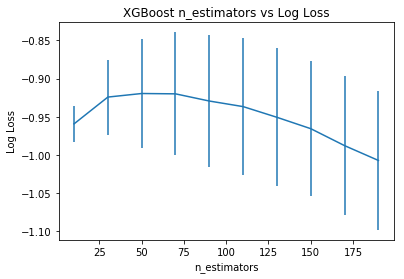

In [15]:
plt.errorbar(n_estimators, means, yerr=stds)
plt.title("XGBoost n_estimators vs Log Loss")
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')

Tune max_depth on the XGBoost model with grid search

In [16]:
max_depth = range(1, 22, 2)
param_grid = dict(max_depth=max_depth)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    6.2s finished


Print out results

In [17]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.933391 using {'max_depth': 3}
-0.933485 (0.039567) with: {'max_depth': 1}
-0.933391 (0.089447) with: {'max_depth': 3}
-0.977448 (0.111410) with: {'max_depth': 5}
-1.055279 (0.133921) with: {'max_depth': 7}
-1.072055 (0.127804) with: {'max_depth': 9}
-1.096605 (0.130874) with: {'max_depth': 11}
-1.118535 (0.141762) with: {'max_depth': 13}
-1.116230 (0.147583) with: {'max_depth': 15}
-1.117186 (0.136738) with: {'max_depth': 17}
-1.114790 (0.140103) with: {'max_depth': 19}
-1.118148 (0.138950) with: {'max_depth': 21}


Plot max_depth vs performance

Text(0,0.5,'Log Loss')

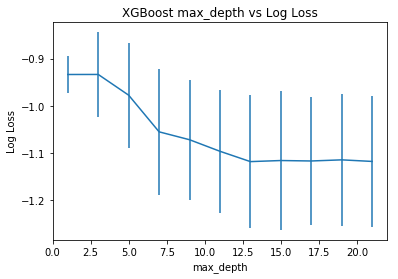

In [18]:
plt.errorbar(max_depth, means, yerr=stds)
plt.title("XGBoost max_depth vs Log Loss")
plt.xlabel('max_depth')
plt.ylabel('Log Loss')

Apply parameters to XGBoost and run

In [19]:
def run_parameterized_xgb(X_train, y_train, X_test, y_test):
    xgb1 = XGBClassifier(
        learning_rate=0.1,
        n_estimators=70,
        max_depth=3,
        min_child_weight=6,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
    xgb1.fit(X_train, y_train)
    y_pred_test = xgb1.predict(X_test)

    print('Accuracy of XGboost on training set: {:.2f}'.format(xgb1.score(X_train, y_train)))
    print('Accuracy of XGboost on test set: {:.2f}'.format(xgb1.score(X_test, y_test)))
    print('Confusion matrix:')
    print(confusion_matrix(y_test, y_pred_test))

In [20]:
run_parameterized_xgb(X_train, y_train, X_test, y_test)

Accuracy of XGboost on training set: 0.80
Accuracy of XGboost on test set: 0.55
Confusion matrix:
[[ 1  6  1]
 [ 1 32  5]
 [ 0 17  4]]


# Feature Engineering & Modeling

### Add 1/x columns

In [21]:
for col in shenzhen.columns[:10]:
    shenzhen['1/'+col] = 1/(shenzhen[col])

shenzhen.head()

,Kitchen_waste_,Fruit_and_vegetable_waste_,Bread_Paste_,Waste_oil_,Total_Waste_,Diesel_waste_water_,Flour_and_waste_oil_,Kitchen_waste_paste_,acid_feed,acid_discharge,...,1/Kitchen_waste_,1/Fruit_and_vegetable_waste_,1/Bread_Paste_,1/Waste_oil_,1/Total_Waste_,1/Diesel_waste_water_,1/Flour_and_waste_oil_,1/Kitchen_waste_paste_,1/acid_feed,1/acid_discharge
0,92.03,0.0,7.95,13.54,99.98,54.0,17.0,167.0,135.0,200.0,...,0.010866,inf,0.125786,0.073855,0.010002,0.018519,0.058824,0.005988,0.007407,0.005000
1,78.43,0.0,13.30,16.10,91.73,36.0,8.0,100.0,91.0,155.0,...,0.012750,inf,0.075188,0.062112,0.010902,0.027778,0.125000,0.010000,0.010989,0.006452
2,81.84,0.0,8.35,6.60,90.19,22.0,34.0,120.0,50.0,160.0,...,0.012219,inf,0.119760,0.151515,0.011088,0.045455,0.029412,0.008333,0.020000,0.006250
3,81.05,0.0,9.10,17.48,90.15,22.0,20.0,92.0,95.0,150.0,...,0.012338,inf,0.109890,0.057208,0.011093,0.045455,0.050000,0.010870,0.010526,0.006667
4,36.86,0.0,9.40,12.47,46.26,44.0,35.0,122.0,9.0,150.0,...,0.027130,inf,0.106383,0.080192,0.021617,0.022727,0.028571,0.008197,0.111111,0.006667


Replace invalid values

In [22]:
shenzhen.replace(float('inf'), 0, inplace=True);
train_data, test_data = train_test_split(shenzhen, test_size=0.2)

Reset the train and test data

In [23]:
INVERSE_COLUMNS = [ 'Kitchen_waste_', 'Fruit_and_vegetable_waste_', 'Bread_Paste_',\
                    'Waste_oil_', 'Total_Waste_', 'Diesel_waste_water_',\
                    'Flour_and_waste_oil_', 'Kitchen_waste_paste_', 'acid_feed',\
                    'acid_discharge','1/Kitchen_waste_', '1/Fruit_and_vegetable_waste_',\
                    '1/Bread_Paste_', '1/Waste_oil_', '1/Total_Waste_',\
                    '1/Diesel_waste_water_', '1/Flour_and_waste_oil_',\
                    '1/Kitchen_waste_paste_', '1/acid_feed', '1/acid_discharge']

X_train = train_data[INVERSE_COLUMNS]
y_train = train_data.anaerobic_dailyoutput
X_test = test_data[INVERSE_COLUMNS]
y_test = test_data.anaerobic_dailyoutput

Run vanilla XGBoost

In [24]:
run_vanilla_xgb(X_train, y_train, X_test, y_test)

Accuracy of XGboost on train set: 0.93
Accuracy of XGboost on test set: 0.63
Confusion matrix:
[[ 2  7  0]
 [ 1 43  6]
 [ 0 19 11]]


Run tuned XGBoost

In [25]:
run_parameterized_xgb(X_train, y_train, X_test, y_test)

Accuracy of XGboost on training set: 0.86
Accuracy of XGboost on test set: 0.63
Confusion matrix:
[[ 1  8  0]
 [ 2 43  5]
 [ 0 18 12]]


### Add x**2 columns

In [26]:
for col in shenzhen.columns[:10]:
    shenzhen[col+"**2"] = (shenzhen[col])**2
    
shenzhen.head()

,Kitchen_waste_,Fruit_and_vegetable_waste_,Bread_Paste_,Waste_oil_,Total_Waste_,Diesel_waste_water_,Flour_and_waste_oil_,Kitchen_waste_paste_,acid_feed,acid_discharge,...,Kitchen_waste_**2,Fruit_and_vegetable_waste_**2,Bread_Paste_**2,Waste_oil_**2,Total_Waste_**2,Diesel_waste_water_**2,Flour_and_waste_oil_**2,Kitchen_waste_paste_**2,acid_feed**2,acid_discharge**2
0,92.03,0.0,7.95,13.54,99.98,54.0,17.0,167.0,135.0,200.0,...,8469.5209,0.0,63.2025,183.3316,9996.0004,2916.0,289.0,27889.0,18225.0,40000.0
1,78.43,0.0,13.30,16.10,91.73,36.0,8.0,100.0,91.0,155.0,...,6151.2649,0.0,176.8900,259.2100,8414.3929,1296.0,64.0,10000.0,8281.0,24025.0
2,81.84,0.0,8.35,6.60,90.19,22.0,34.0,120.0,50.0,160.0,...,6697.7856,0.0,69.7225,43.5600,8134.2361,484.0,1156.0,14400.0,2500.0,25600.0
3,81.05,0.0,9.10,17.48,90.15,22.0,20.0,92.0,95.0,150.0,...,6569.1025,0.0,82.8100,305.5504,8127.0225,484.0,400.0,8464.0,9025.0,22500.0
4,36.86,0.0,9.40,12.47,46.26,44.0,35.0,122.0,9.0,150.0,...,1358.6596,0.0,88.3600,155.5009,2139.9876,1936.0,1225.0,14884.0,81.0,22500.0


In [27]:
train_data, test_data = train_test_split(shenzhen, test_size=0.15)

Reset the train and test data

In [28]:
SQUARED_COLUMNS = [ 'Kitchen_waste_', 'Fruit_and_vegetable_waste_', 'Bread_Paste_',\
                     'Waste_oil_', 'Total_Waste_', 'Diesel_waste_water_',\
                     'Flour_and_waste_oil_', 'Kitchen_waste_paste_', 'acid_feed',\
                     'acid_discharge','1/Kitchen_waste_', '1/Fruit_and_vegetable_waste_',\
                     '1/Bread_Paste_', '1/Waste_oil_', '1/Total_Waste_',\
                     '1/Diesel_waste_water_', '1/Flour_and_waste_oil_',\
                     '1/Kitchen_waste_paste_', '1/acid_feed', '1/acid_discharge',\
                     'Kitchen_waste_**2', 'Fruit_and_vegetable_waste_**2', \
                     'Bread_Paste_**2','Waste_oil_**2', 'Total_Waste_**2', \
                     'Diesel_waste_water_**2','Flour_and_waste_oil_**2', \
                     'Kitchen_waste_paste_**2', 'acid_feed**2','acid_discharge**2' ]

X_train = train_data[SQUARED_COLUMNS]
y_train = train_data.anaerobic_dailyoutput
X_test = test_data[SQUARED_COLUMNS]
y_test = test_data.anaerobic_dailyoutput

Run vanilla XGBoost

In [29]:
run_vanilla_xgb(X_train, y_train, X_test, y_test)

Accuracy of XGboost on train set: 0.92
Accuracy of XGboost on test set: 0.51
Confusion matrix:
[[ 0 14  0]
 [ 5 27  2]
 [ 0 12  7]]


Run tuned XGBoost

In [30]:
run_parameterized_xgb(X_train, y_train, X_test, y_test)

Accuracy of XGboost on training set: 0.85
Accuracy of XGboost on test set: 0.48
Confusion matrix:
[[ 0 13  1]
 [ 4 27  3]
 [ 0 14  5]]


### Add log(x) columns

In [31]:
for col in shenzhen.columns[:10]:
    shenzhen[col+"log"] = np.log(shenzhen[col])
    
shenzhen.head()

,Kitchen_waste_,Fruit_and_vegetable_waste_,Bread_Paste_,Waste_oil_,Total_Waste_,Diesel_waste_water_,Flour_and_waste_oil_,Kitchen_waste_paste_,acid_feed,acid_discharge,...,Kitchen_waste_log,Fruit_and_vegetable_waste_log,Bread_Paste_log,Waste_oil_log,Total_Waste_log,Diesel_waste_water_log,Flour_and_waste_oil_log,Kitchen_waste_paste_log,acid_feedlog,acid_dischargelog
0,92.03,0.0,7.95,13.54,99.98,54.0,17.0,167.0,135.0,200.0,...,4.522115,-inf,2.073172,2.605648,4.604970,3.988984,2.833213,5.117994,4.905275,5.298317
1,78.43,0.0,13.30,16.10,91.73,36.0,8.0,100.0,91.0,155.0,...,4.362207,-inf,2.587764,2.778819,4.518849,3.583519,2.079442,4.605170,4.510860,5.043425
2,81.84,0.0,8.35,6.60,90.19,22.0,34.0,120.0,50.0,160.0,...,4.404766,-inf,2.122262,1.887070,4.501919,3.091042,3.526361,4.787492,3.912023,5.075174
3,81.05,0.0,9.10,17.48,90.15,22.0,20.0,92.0,95.0,150.0,...,4.395066,-inf,2.208274,2.861057,4.501475,3.091042,2.995732,4.521789,4.553877,5.010635
4,36.86,0.0,9.40,12.47,46.26,44.0,35.0,122.0,9.0,150.0,...,3.607127,-inf,2.240710,2.523326,3.834278,3.784190,3.555348,4.804021,2.197225,5.010635


In [32]:
train_data, test_data = train_test_split(shenzhen, test_size=0.15)

Reset the train and test data

In [33]:
LOG_COLUMNS = [ 'Kitchen_waste_', 'Fruit_and_vegetable_waste_', 'Bread_Paste_',\
                 'Waste_oil_', 'Total_Waste_', 'Diesel_waste_water_',\
                 'Flour_and_waste_oil_', 'Kitchen_waste_paste_', 'acid_feed',\
                 'acid_discharge','1/Kitchen_waste_', '1/Fruit_and_vegetable_waste_',\
                 '1/Bread_Paste_', '1/Waste_oil_', '1/Total_Waste_',\
                 '1/Diesel_waste_water_', '1/Flour_and_waste_oil_',\
                 '1/Kitchen_waste_paste_', '1/acid_feed', '1/acid_discharge',\
                 'Kitchen_waste_**2', 'Fruit_and_vegetable_waste_**2', \
                 'Bread_Paste_**2','Waste_oil_**2', 'Total_Waste_**2', \
                 'Diesel_waste_water_**2','Flour_and_waste_oil_**2', \
                 'Kitchen_waste_paste_**2', 'acid_feed**2','acid_discharge**2',\
                 'Kitchen_waste_log','Fruit_and_vegetable_waste_log', \
                 'Bread_Paste_log', 'Waste_oil_log','Total_Waste_log', \
                 'Diesel_waste_water_log', 'Flour_and_waste_oil_log',\
                 'Kitchen_waste_paste_log', 'acid_feedlog', 'acid_dischargelog' ]

X_train = train_data[LOG_COLUMNS]
y_train = train_data.anaerobic_dailyoutput
X_test = test_data[LOG_COLUMNS]
y_test = test_data.anaerobic_dailyoutput

Run vanilla XGBoost

In [34]:
run_vanilla_xgb(X_train, y_train, X_test, y_test)

Accuracy of XGboost on train set: 0.94
Accuracy of XGboost on test set: 0.57
Confusion matrix:
[[ 1  8  1]
 [ 3 32  5]
 [ 0 12  5]]


Run tuned XGBoost

In [35]:
run_parameterized_xgb(X_train, y_train, X_test, y_test)

Accuracy of XGboost on training set: 0.84
Accuracy of XGboost on test set: 0.60
Confusion matrix:
[[ 0 10  0]
 [ 1 33  6]
 [ 0 10  7]]


__Conclusion: the best model is treated with 1/, x\**2 and log(x)__

### Adding a time-series value

Consolidate some columns

In [36]:
shenzhen = pd.read_csv("Data/shenzhen_cleaned_data.csv")
shenzhen['acid_feed'] = shenzhen['1_acidification_hydrolysis_tank_feed_'] \
                                             + shenzhen['2_acidification_hydrolysis_tank_feed_']
shenzhen['acid_discharge']  = shenzhen['1_acidification_hydrolysis_tank_discharge_']\
                                             + shenzhen['2_acidification_hydrolysis_tank_discharge_']
shenzhen['anaerobic_feed'] = shenzhen['1_Anaerobic_tank_slurry_feed_'] \
                                             + shenzhen['2_Anaerobic_tank_slurry_feed_']
shenzhen['anaerobic_cumuprod'] = shenzhen['1_Anaerobic_tank_biogas_cumulative_production_'] \
                                             + shenzhen['2_anaerobic_tank_biogas_cumulative_production_']
shenzhen['anaerobic_dailyoutput'] = shenzhen['1_anaerobic_tank_biogas_daily_output_'] \
                                             + shenzhen['2_anaerobic_tank_biogas_daily_output_']
shenzhen = shenzhen.drop(['1_acidification_hydrolysis_tank_feed_','2_acidification_hydrolysis_tank_feed_',\
               '1_acidification_hydrolysis_tank_discharge_','2_acidification_hydrolysis_tank_discharge_',\
               '1_Anaerobic_tank_slurry_feed_','2_Anaerobic_tank_slurry_feed_',\
               '1_Anaerobic_tank_biogas_cumulative_production_','2_anaerobic_tank_biogas_cumulative_production_',\
               '1_anaerobic_tank_biogas_daily_output_','2_anaerobic_tank_biogas_daily_output_'],axis=1)

shenzhen.head()

,Unnamed: 0,Kitchen_waste_,Fruit_and_vegetable_waste_,Bread_Paste_,Waste_oil_,Total_Waste_,Diesel_waste_water_,Flour_and_waste_oil_,Kitchen_waste_paste_,acid_feed,acid_discharge,anaerobic_feed,anaerobic_cumuprod,anaerobic_dailyoutput
0,0,92.03,0.0,7.95,13.54,99.98,54.0,17.0,167.0,0.0,0.0,130.0,340453.0,7919.0
1,1,78.43,0.0,13.30,16.10,91.73,36.0,8.0,100.0,0.0,0.0,170.0,343154.0,2701.0
2,2,81.84,0.0,8.35,6.60,90.19,22.0,34.0,120.0,0.0,0.0,150.0,353361.0,10207.0
3,3,81.05,0.0,9.10,17.48,90.15,22.0,20.0,92.0,0.0,0.0,160.0,363943.0,10582.0
4,4,36.86,0.0,9.40,12.47,46.26,44.0,35.0,122.0,0.0,0.0,160.0,372971.0,9028.0


Shift rows up to account for production delay

In [37]:
shenzhen.acid_feed = shenzhen.acid_feed.shift(-15)
shenzhen.acid_discharge = shenzhen.acid_discharge.shift(-15)
shenzhen.anaerobic_feed = shenzhen.anaerobic_feed.shift(-15)
shenzhen.anaerobic_cumuprod = shenzhen.anaerobic_cumuprod.shift(-15)
shenzhen.anaerobic_dailyoutput = shenzhen.anaerobic_dailyoutput.shift(-15)
shenzhen = shenzhen.drop(['Unnamed: 0'], axis=1)
shenzhen = shenzhen[:-15]
shenzhen.tail()

,Kitchen_waste_,Fruit_and_vegetable_waste_,Bread_Paste_,Waste_oil_,Total_Waste_,Diesel_waste_water_,Flour_and_waste_oil_,Kitchen_waste_paste_,acid_feed,acid_discharge,anaerobic_feed,anaerobic_cumuprod,anaerobic_dailyoutput
436,150.03,25.45,0.0,6.49,175.48,44.0,0.0,151.0,0.0,200.0,200.0,3091363.0,7526.0
437,144.28,49.36,0.0,10.04,193.64,44.0,0.0,145.0,0.0,210.0,210.0,3098699.0,7336.0
438,98.96,32.86,0.0,9.79,131.82,0.0,0.0,101.0,0.0,230.0,230.0,3105678.0,6979.0
439,86.92,32.11,0.0,11.71,119.03,44.0,0.0,89.0,0.0,220.0,220.0,3112064.0,6626.0
440,158.93,33.02,0.0,9.10,191.95,0.0,0.0,160.0,0.0,230.0,230.0,3119057.0,6993.0


Add a moving average column

In [38]:
shenzhen['daymean'] = np.nan

In [39]:
shenzhen.head()

,Kitchen_waste_,Fruit_and_vegetable_waste_,Bread_Paste_,Waste_oil_,Total_Waste_,Diesel_waste_water_,Flour_and_waste_oil_,Kitchen_waste_paste_,acid_feed,acid_discharge,anaerobic_feed,anaerobic_cumuprod,anaerobic_dailyoutput,daymean
0,92.03,0.0,7.95,13.54,99.98,54.0,17.0,167.0,135.0,200.0,200.0,464356.0,9295.0,NaN
1,78.43,0.0,13.30,16.10,91.73,36.0,8.0,100.0,91.0,155.0,155.0,472980.0,8624.0,NaN
2,81.84,0.0,8.35,6.60,90.19,22.0,34.0,120.0,50.0,160.0,160.0,481426.0,8446.0,NaN
3,81.05,0.0,9.10,17.48,90.15,22.0,20.0,92.0,95.0,150.0,150.0,490210.0,8784.0,NaN
4,36.86,0.0,9.40,12.47,46.26,44.0,35.0,122.0,9.0,150.0,150.0,497959.0,7749.0,NaN


Iterate through the table and update the moving average accordingly

In [40]:
for index, row in shenzhen.iterrows():
    if index == 0:
        shenzhen.daymean[index] = shenzhen.anaerobic_dailyoutput[index]
    elif index == 1:
        shenzhen.daymean[index] = shenzhen.anaerobic_dailyoutput[index]
    elif index == 2:
        shenzhen.daymean[index] = shenzhen.anaerobic_dailyoutput[index]    
    else:
        shenzhen.daymean[index] = (shenzhen.daymean[index-1] + shenzhen.daymean[index-2] +\
                                   shenzhen.daymean[index-3])/3

In [41]:
shenzhen.head()

,Kitchen_waste_,Fruit_and_vegetable_waste_,Bread_Paste_,Waste_oil_,Total_Waste_,Diesel_waste_water_,Flour_and_waste_oil_,Kitchen_waste_paste_,acid_feed,acid_discharge,anaerobic_feed,anaerobic_cumuprod,anaerobic_dailyoutput,daymean
0,92.03,0.0,7.95,13.54,99.98,54.0,17.0,167.0,135.0,200.0,200.0,464356.0,9295.0,9295.000000
1,78.43,0.0,13.30,16.10,91.73,36.0,8.0,100.0,91.0,155.0,155.0,472980.0,8624.0,8624.000000
2,81.84,0.0,8.35,6.60,90.19,22.0,34.0,120.0,50.0,160.0,160.0,481426.0,8446.0,8446.000000
3,81.05,0.0,9.10,17.48,90.15,22.0,20.0,92.0,95.0,150.0,150.0,490210.0,8784.0,8788.333333
4,36.86,0.0,9.40,12.47,46.26,44.0,35.0,122.0,9.0,150.0,150.0,497959.0,7749.0,8619.444444


Bin the output

In [42]:
shenzhen.anaerobic_dailyoutput = pd.cut(shenzhen['anaerobic_dailyoutput'], bins=3)
shenzhen.anaerobic_dailyoutput = pd.factorize(shenzhen.anaerobic_dailyoutput)[0]

Perform the feature engineering from before

In [43]:
for col in shenzhen.columns[:10]:
    shenzhen['1/'+col] = 1/(shenzhen[col])
for col in shenzhen.columns[:10]:
    shenzhen[col+"**2"] = (shenzhen[col])**2
for col in shenzhen.columns[:10]:
    shenzhen[col+"log"] = np.log(shenzhen[col])

Remove invalid values

In [44]:
shenzhen.replace(float('inf'), 0, inplace=True)
shenzhen.replace(float('-inf'), 0, inplace=True);

In [45]:
shenzhen_train, shenzhen_test = train_test_split(shenzhen, test_size=0.15)

In [46]:
DAYMEAN_COLUMNS = [ 'Kitchen_waste_', 'Fruit_and_vegetable_waste_', 'Bread_Paste_',\
                     'Waste_oil_', 'Total_Waste_', 'Diesel_waste_water_',\
                     'Flour_and_waste_oil_', 'Kitchen_waste_paste_', 'acid_feed',\
                     'acid_discharge','daymean','1/Kitchen_waste_', '1/Fruit_and_vegetable_waste_',\
                     '1/Bread_Paste_', '1/Waste_oil_', '1/Total_Waste_',\
                     '1/Diesel_waste_water_', '1/Flour_and_waste_oil_',\
                     '1/Kitchen_waste_paste_', '1/acid_feed', '1/acid_discharge',\
                     'Kitchen_waste_**2', 'Fruit_and_vegetable_waste_**2', \
                     'Bread_Paste_**2','Waste_oil_**2', 'Total_Waste_**2', \
                     'Diesel_waste_water_**2','Flour_and_waste_oil_**2', \
                     'Kitchen_waste_paste_**2', 'acid_feed**2','acid_discharge**2',\
                     'Kitchen_waste_log','Fruit_and_vegetable_waste_log', \
                     'Bread_Paste_log', 'Waste_oil_log','Total_Waste_log', \
                     'Diesel_waste_water_log', 'Flour_and_waste_oil_log',\
                     'Kitchen_waste_paste_log', 'acid_feedlog', 'acid_dischargelog' ]
X_train = shenzhen_train[DAYMEAN_COLUMNS]
y_train = shenzhen_train.anaerobic_dailyoutput
X_test = shenzhen_test[DAYMEAN_COLUMNS]
y_test = shenzhen_test.anaerobic_dailyoutput

Run vanilla XGBoost

In [47]:
run_vanilla_xgb(X_train, y_train, X_test, y_test)

Accuracy of XGboost on train set: 0.91
Accuracy of XGboost on test set: 0.60
Confusion matrix:
[[ 0  8  1]
 [ 0 35 10]
 [ 0  8  5]]


Run tuned XGBoost

In [48]:
run_parameterized_xgb(X_train, y_train, X_test, y_test)

Accuracy of XGboost on training set: 0.83
Accuracy of XGboost on test set: 0.63
Confusion matrix:
[[ 2  6  1]
 [ 1 35  9]
 [ 0  8  5]]


# Other models

### Logistic Regression

In [49]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_test = logreg.predict(X_test)

print('Accuracy of logistic regression classifier on training set: {:.2f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print('Confusion matrix:') 
print(confusion_matrix(y_test, y_pred_test))

Accuracy of logistic regression classifier on training set: 0.63
Accuracy of logistic regression classifier on test set: 0.61
Confusion matrix:
[[ 1  7  1]
 [ 0 35 10]
 [ 0  8  5]]


### SVM

In [50]:
clf = svm.SVC()
clf.fit(X_train, y_train)  
y_pred_test = clf.predict(X_test)

print('Accuracy of SVM on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Accuracy of SVM on test set: {:.2f}'.format(clf.score(X_test, y_test)))

Accuracy of SVM on training set: 1.00
Accuracy of SVM on test set: 0.67


### Random forest

In [51]:
random_forest = RandomForestClassifier(n_estimators=50)
random_forest.fit(X_train, y_train)

print('Accuracy of Random Forest on training set: {:.2f}'.format(random_forest.score(X_train, y_train)))
print('Accuracy of Random Forest on test set: {:.2f}'.format(random_forest.score(X_test, y_test)))

Accuracy of Random Forest on training set: 1.00
Accuracy of Random Forest on test set: 0.61


Analyze feature importance using random forest

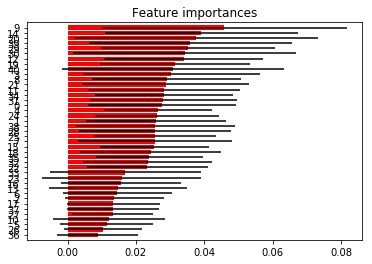

In [52]:
importances = random_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)
indices = np.argsort(importances)

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices],
         color="r", xerr=std[indices], align="center")
plt.yticks(range(X_train.shape[1]), indices)
plt.ylim([-1, X_train.shape[1]])
plt.show()